# DS 5001 Project Notebook: Greek and Roman Mythology

- David Vann (dv6bq@virginia.edu)
- DS 5001
- 5 May 2021

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import nltk

from eta_modules.preprocessing import Document, Corpus
from eta_modules.analysis import HierarchicalClusterAnalysis

In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

## Reading in the data

We start by loading in the XML files for each work and parsing them to a reasonable degree with BeautifulSoup and NLTK. 

Since these works are all either plays or poems/epics, the concept of a "chapter" or "paragraph" doesn't translate perfectly compared to, e.g., a novel. However, the Perseus Digital Library (where these files are sourced from) has added at least top-level divisions to break up texts. In some cases, these divisions truly exist in the text (for example, *The Iliad* is broken into 24 books); in other cases, like plays, these divisions don't seem to be directly present in the text, but are akin to something like a "scene". I've considered all of these largest divisions as "chapters".

To get at something like a "paragraph", I used a different approach based on whether the work was a play or not:

- For plays, I used each speaker section (denoted by a "\<sp>" in the files) as a "paragraph". 
- For everything else, there wasn't a built-in tag for "paragraph"-type divisions, but there is a self-closing "milestone" tag that marks the start of a new "card" used on the Perseus website to denote content to be displayed on one page. Since these are self-closing, they don't actually enclose the particular block of text that I wanted to get at; instead, I replaced these with newlines and split up text based on a double newline, which seemed to give fairly satisfactory results.

In [11]:
root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')
output_dir = os.path.join(data_dir, 'outputs')

docpaths = glob(os.path.join(data_dir, 'raw', '**', '*.xml'), recursive=True) # Get all XML file paths
corpus_tables = glob(os.path.join(output_dir, 'corpus', '*.csv')) # Check if there's already pre-computed corpus tables to save time

OHCO = ['work_id', 'chapter_id', 'para_id', 'sent_id']
book_bag = OHCO[:1]
chapter_bag = OHCO[:2]
paragraph_bag = OHCO[:3]

In [16]:
alist = []
len(alist) == 0

True

In [12]:
corpus_tables

['C:\\Users\\David\\Documents\\GitHub\\latin-greek-text-analytics\\data\\outputs\\corpus\\DOC.csv',
 'C:\\Users\\David\\Documents\\GitHub\\latin-greek-text-analytics\\data\\outputs\\corpus\\LIB.csv',
 'C:\\Users\\David\\Documents\\GitHub\\latin-greek-text-analytics\\data\\outputs\\corpus\\TOKEN.csv',
 'C:\\Users\\David\\Documents\\GitHub\\latin-greek-text-analytics\\data\\outputs\\corpus\\VOCAB.csv']

In [5]:
def parse_corpus(docpaths, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    doc_list = []
    for path in docpaths:
        doc = Document(path)
        doc.parse_text_to_paras()
        doc.tokenize(remove_pos_tuple=True, remove_ws=True)
        doc_list.append(doc)

    corpus = Corpus(doc_list)
    corpus.extract_annotate_vocab()
    corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
    
    return doc_list, corpus

In [6]:
if 

doc_list, corp = parse_corpus(docpaths, tfidf_bag=chapter_bag)

In [7]:
corp.vocab.sort_values('tfidf_bool_sum', ascending=False).head(10)

,n,stop,p_stem,df,idf,tfidf_n_sum,tfidf_max_sum,tfidf_bool_sum
term_str,,,,,,,,
sing,87,0,sing,58,2.208108,1.816905,4.661218,20.941718
hail,96,0,hail,66,2.021695,1.835607,4.764603,18.136252
song,172,0,song,81,1.726239,2.808162,5.019914,15.020710
begin,51,0,begin,38,2.818162,1.359342,3.795364,13.793796
chorus,841,0,choru,138,0.957565,7.616525,5.562277,12.176520
zeus,1270,0,zeu,170,0.656698,7.887916,4.092533,9.574987
muse,22,0,muse,18,3.896164,0.810686,2.520064,9.125414
lovely,152,0,love,53,2.338169,3.361338,4.336112,8.647434
bare,173,0,bare,63,2.088809,3.417729,4.530909,8.549576


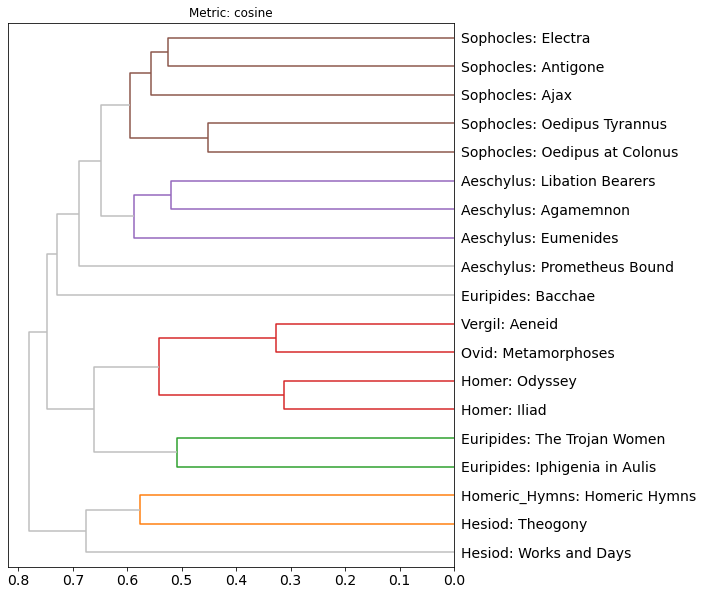

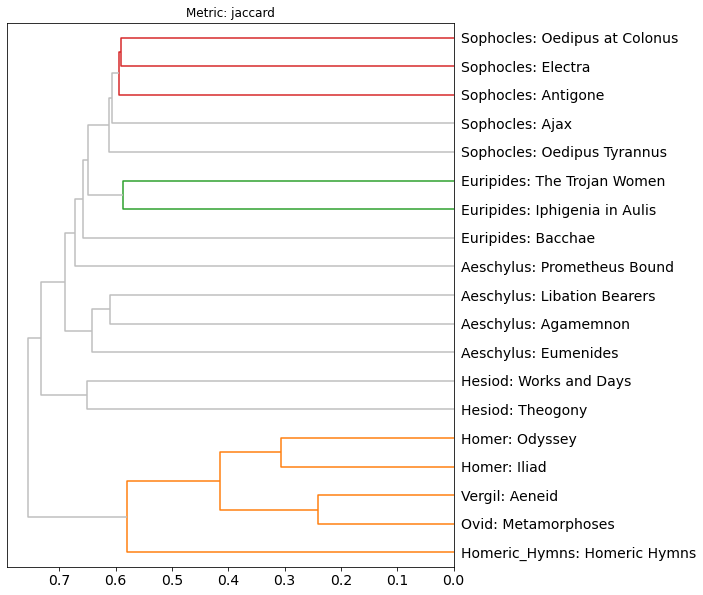

In [8]:
hca = HierarchicalClusterAnalysis(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
hca.fit(corp, metrics=['cosine', 'jaccard'])
hca.plot_dendrogram(linkage='complete', color_thresh=0.6, figsize=(8, 10))

In [10]:
corp.save_tables(os.path.join(output_dir, 'corpus'))